# 第四章： 动态规划算法（Dynamic Programming）  

## 介绍（Introduction）

在本次实验中，掌握策略迭代算法和价值迭代算法

***
# 涉及核心概念回顾： 参考课堂上ppt
***

##### 导入实验所需要的库

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

%matplotlib inline

<div class="alert alert-block alert-warning">

**主题1： 创建悬崖漫步环境** （10分）
</div>

<img src="./cliff_walking.jpg" style="zoom:50%" />

问题描述。
悬崖漫步是一个非常经典的强化学习环境，它要求一个智能体从起点出发，避开悬崖行走，最终到达目标位置。如图 4-1 所示，有一个 4×12 的网格世界，每一个网格表示一个状态。智能体的起点是左下角的状态，目标是右下角的状态，智能体在每一个状态都可以采取 4 种动作：上、下、左、右。如果智能体采取动作后触碰到边界墙壁则状态不发生改变，否则就会相应到达下一个状态。环境中有一段悬崖，智能体掉入悬崖或到达目标状态都会结束动作并回到起点，也就是说掉入悬崖或者达到目标状态是终止状态。智能体每走一步的奖励是 −1，掉入悬崖的奖励是 −100。

In [2]:
class CliffWalkingEnv:
    """ 悬崖漫步环境"""
    def __init__(self, ncol=12, nrow=4):
        """<S, A, P, R, gamma>
        """
        self.ncol = ncol  # 定义网格世界的列
        self.nrow = nrow  # 定义网格世界的行
        # 四参数p(s',r|s,a)的定义,包含下一个状态和奖励
        # p: 下一个状态的概率, next_state: 下一个状态, reward: 奖励, done: 是否终止
        # self.P[state][action] = [(p, next_state, reward, done)]
        self.P = self.createP()

    def createP(self):
        # 初始化
        P = [[[] for j in range(4)] for i in range(self.nrow * self.ncol)]
        # 4种动作, change[0]:上,change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0), 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        for i in range(self.nrow):
            for j in range(self.ncol):
                # 对于每一个状态,我们尝试所有4个动作,这给我们了每个下一个状态的概率, 下一个状态，奖励,以及每个动作是否终止的概率
                for a in range(4):
                    # 边界条件
                    if i == self.nrow - 1 and j > 0:
                        # 位置在悬崖或者目标状态,因为无法继续交互,任何动作奖励都为0
                        # （下一个状态概率，下一个状态，奖励，是否终止）
                        P[i * self.ncol + j][a] = [(1, i * self.ncol + j, 0,
                                                    True)]
                        continue
                    else: 
                        # 下一个位置
                        next_x = min(self.ncol - 1, max(0, j + change[a][0]))
                        next_y = min(self.nrow - 1, max(0, i + change[a][1]))
                        next_state = next_y * self.ncol + next_x
                        reward = -1
                        done = False
                        # 下一个位置在悬崖或者终点
                        if next_y == self.nrow - 1 and next_x > 0:
                            done = True
                            if next_x != self.ncol - 1:  # 下一个位置在悬崖
                                reward = -100
                        P[i * self.ncol + j][a] = [(1, next_state, reward, done)]
        return P

# 创建悬崖漫步环境
env = CliffWalkingEnv()

**测试1-1**：阅读上述代码，回答如下几个问题

回答问题1： 状态空间大小为 [12*4=48]。

回答问题2： 动作空间大小为 [4]。

回答问题3： 终止状态为 [悬崖区域和终点位置，即最后一行除了起点外的所有位置都可为终止状态]。

回答问题4： 上述环境是否为有限MDP问题 [是]，能否有四参数p唯一确定 [是]。  状态空间和动作空间都有限


注：在 [填写答案] 填写答案。

<div class="alert alert-block alert-warning">

**主题2： 策略迭代 （90分）** 
</div>


**测试2-1**：背景知识如下：

策略迭代: 策略迭代是策略评估和策略提升不断循环交替，直至最后得到最优策略的过程

$$
\pi_0 \overset{\text{策略评估}}{->} v_{\pi_0} \overset{\text{策略提升}}{->} \pi_1 \overset{\text{策略评估}}{->} v_{\pi_1} \overset{\text{策略提升}}{->} \pi_2 ... \overset{\text{策略提升}}{->} \pi_* \overset{\text{策略评估}}{->} v_{\pi_*}
$$


- 策略评估： 评估一个策略的状态价值函数，主要基于如下贝尔曼方程：
$$
v_{\pi}(s) = \sum_{a \in \mathcal{A}} \pi(a|s) * sum_{s', r}p(s',r|s,a) * [r + \gamma v(s')], \quad\text{for all}\quad s \in \mathcal{S}
$$

注意: 上述公式也可写成如下：

$v_\pi(s) = \sum_{a \in \mathcal{A}}  \pi(a|s)  q_\pi(s, a)$

策略评估时，我们用上一轮的状态函数估值更新当前轮状态函数估值，从而更准确的估计出$v_{\pi}(\cdot)$

$$
v^{k+1}_{\pi}(s) = \sum_{a \in \mathcal{A}} \pi(a|s) * \sum_{s', r}p(s',r|s,a) * [r + \gamma v^{k}(s')^{k+1}], \quad\text{for all}\quad s \in \mathcal{S}
$$

- 策略改进： 使用策略评估计算得到当前策略的状态价值函数之后，我们可以据此来改进该策略。

- 贪心的策略提升如下：
$$
\pi'(s) = \text{argmax}_a q_\pi(s, a) 
$$



In [3]:
class PolicyIteration:
    """ 策略迭代算法 """
    def __init__(self, env, theta, gamma):
        self.env = env
        self.v = [0] * self.env.ncol * self.env.nrow  # 初始化价值为0
        # 初始化策略为均匀随机策略
        self.pi = self.get_equiprobable_random_policy(env)
        
        self.theta = theta  # 策略评估收敛阈值
        self.gamma = gamma  # 折扣因子

    def get_equiprobable_random_policy(self, env):  
        """ 均匀随机策略
        参数:
        - env: object
            环境对象
        返回:
        - pi: list
            包含策略的列表
        """
        # 
        # ******************测试1（TODO）: 定义一个等概率随机策略（10分）******************
        # 例子：对于4*4的网格世界，每个状态的策略为[0.25, 0.25, 0.25, 0.25]，即每个动作的概率相等
        # [[0.25, 0.25, 0.25, 0.25], [0.25, 0.25, 0.25, 0.25], ...]] 
        n_a = 4 #动作空间大小
        n_s = env.ncol * env.nrow #状态空间大小
        pi = [[1/n_a] * n_a for _ in range(n_s)]
        
        return pi
    def cal_qsa_list(self, s): 
        """ 给定状态，返回在该状态下执行当前策略不同动作的价值 (注意：依赖self.env.P和self.v)
        参数:
        - s: int
            输入的状态s
        返回:
        - qsa_list: list
            包含Q(s,a)的列表，a=0,1,2,3
        """ 
        qsa_list = [0]*4
        # 
        # ******************测试4 (TODO): 计算qsa_list[a] （20分）******************
        # 
        for action in range(4):
            #遍历策略s下的每一个动作a
             # p: 下一个状态的概率, next_state: 下一个状态, reward: 奖励, done: 是否终止
            for prob, next_state, reward, done in self.env.P[s][action]:
                #公式：当前状态的价值 = 累加（动作概率 *（奖励+gamma*下一个状态的价值）） 
                qsa_list[action] += prob * (reward + self.gamma * self.v[next_state])
        
        return qsa_list
    
    
    def policy_evaluation(self):
        """策略评估
        """
        cnt = 1  # 计数器
        while True:
            max_diff = 0
            new_v = [0] * self.env.ncol * self.env.nrow
            for s in range(self.env.ncol * self.env.nrow):
                # 对于每一个状态s, 基于贝尔曼方程计算当前策略下状态价值函数最新近似数值
                qsa_list = self.cal_qsa_list(s)
                
                # 
                # ******************测试2 (TODO): 计算新的状态价值函数 （20分）******************
                # 
                new_v[s] = max(qsa_list)
                
                # 更新最大差值
                max_diff = max(max_diff, abs(new_v[s] - self.v[s]))
            
            # 更新状态价值函数
            self.v = new_v
            
            # 
            # ******************测试3 (TODO): 判断是否满足收敛条件，满足则退出评估迭代 （10分）******************
            # 
            if max_diff < self.theta:
                break  
            
            cnt += 1
        print("策略评估进行%d轮后完成" % cnt)
    
    def greedy_policy_improvement(self):  # 策略提升
        # 遍历每一个状态
        for s in range(self.env.nrow * self.env.ncol):
            # 计算在状态s下执行不同动作的价值
            qsa_list = self.cal_qsa_list(s)
            maxq = max(qsa_list) 
            cntq = qsa_list.count(maxq) 
            
            # 
            # ******************测试5 (TODO): 计算改进后新策略（10）******************
            # 提示：maxq为最大的Q值，cntq为最大Q值的个数，即在状态s下有多少个动作的Q值等于最大Q值
            
            new_policy = [0] * 4 #初始化新策略
            for a in range(4):
                if qsa_list[a] == maxq:  # 若qsa_list=[1, 3, 2, 3], 则maxq=3, cntq=2
                     # 则新的策略为在状态s下，执行最大Q值的动作的概率为1/cntq, 其他动作的概率为0
                    new_policy[a] = 1 / cntq
            self.pi[s] = new_policy # self.pi[s] = [0, 0.5, 0, 0.5]
            
        print("策略提升完成")
        
        return self.pi
    
    def policy_iteration(self):  # 策略迭代
        while True:
            # 
            # ****************** 测试7 (TODO): 更新迭代 （20分）******************
            #先调用策略评估
            self.policy_evaluation()
            #然后利用copy.deepcopy()深拷贝旧的策略
            old_policy = np.copy(self.pi)
            #再调用策略提升
            self.greedy_policy_improvement()
            #最后判断新旧策略是否相同，相同则退出迭代
            if np.array_equal(old_policy, self.pi):
                break
            print("over")

如下代码为打印价值和策略的代码，请调用下面代码实现打印功能。

In [5]:
def plot_v_values(v, nrows, ncols):
    """Plots the value function in each state as a grid.

    Args:
        v (array): numpy array representing the value function
        n (int):
    """

    fig, ax = plt.subplots()
    im = ax.imshow(np.array(v).reshape(nrows, ncols), cmap='YlOrBr', interpolation='nearest')

    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-.5, ncols, 1))
    ax.set_yticks(np.arange(-.5, nrows, 1))

    # Loop over data dimensions and create text annotations.
    for i in range(nrows):
        for j in range(ncols):
            text = ax.text(j, i, "{:.2f}".format(v[i*ncols + j]), ha="center", va="center", color="black")

    ax.set_title("Value function")
    fig.tight_layout()
    plt.show()

In [6]:
def print_agent(agent, action_meaning, disaster=[], end=[]):
    print("状态价值：")
    
    plot_v_values(agent.v, agent.env.nrow, agent.env.ncol)
    
    print("策略：")
    for i in range(agent.env.nrow):
        for j in range(agent.env.ncol):
            if (i * agent.env.ncol + j) in disaster:
                # 一些特殊的状态,例如悬崖漫步中的悬崖
                print('****', end=' ')
            elif (i * agent.env.ncol + j) in end:  
                # 目标状态 
                print('EEEE', end=' ')
            else:
                # 其他状态， 根据策略输出动作
                a = agent.pi[i * agent.env.ncol + j]
                pi_str = ''
                # 遍历四种动作，即上下左右
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()

测试代码如下：

策略评估进行15轮后完成
策略提升完成
over
策略评估进行1轮后完成
策略提升完成
状态价值：


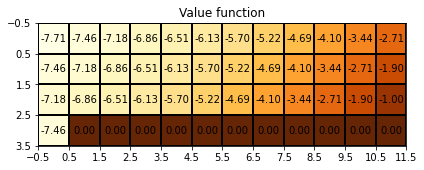

策略：
ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo 
ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [7]:

action_meaning = ['^', 'v', '<', '>']
theta = 0.001
gamma = 0.9
agent = PolicyIteration(env, theta, gamma)
agent.policy_iteration()
print_agent(agent, action_meaning, list(range(37, 47)), [47])

# 策略评估进行60轮后完成
# 策略提升完成
# 策略评估进行72轮后完成
# 策略提升完成
# 策略评估进行44轮后完成
# 策略提升完成
# 策略评估进行12轮后完成
# 策略提升完成
# 策略评估进行1轮后完成
# 策略提升完成
# 状态价值：
# -7.712 -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710
# -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900
# -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 -1.000
# -7.458  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
# 策略：
# ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo
# ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo
# ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo
# ^ooo **** **** **** **** **** **** **** **** **** **** EEEE

<div class="alert alert-block alert-warning">

**总结**
</div>

本章实验以悬崖漫步作为案例，通过策略迭代的方式帮助智能体找到最优策略。

智能体需要从起点出发，穿过网格世界，避开悬崖区域，最终到达目标位置。悬崖区域是一个负奖励区域，智能体进入悬崖会受到较大的惩罚。

策略迭代算法包括**策略评估**和**策略提升**两个步骤。

**策略评估阶段**，通过迭代计算每个状态的价值函数，直到收敛到某个阈值为止。这一过程确保了当前策略的质量。

**策略提升阶段**，基于当前估计的价值函数，更新策略，使得每个状态下选择的动作更加倾向于产生更高的回报。这一过程提高了策略的质量。


<div class="alert alert-block alert-warning">

**附加主题3： 挑战题 (+15)**
</div>

完成cal_qsa_list 和get_policy函数。

价值迭代一共进行14轮
状态价值：


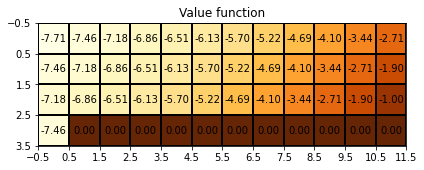

策略：
ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo 
ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [10]:
class ValueIteration:
    """ 价值迭代算法 """
    def __init__(self, env, theta, gamma):
        self.env = env
        self.v = [0] * self.env.ncol * self.env.nrow  # 初始化价值为0
        self.theta = theta  # 价值收敛阈值
        self.gamma = gamma
        # 价值迭代结束后得到的策略
        self.pi = [None for i in range(self.env.ncol * self.env.nrow)]

    def value_iteration(self):
        cnt = 0
        while True:
            max_diff = 0
            new_v = [0] * self.env.ncol * self.env.nrow
            for s in range(self.env.ncol * self.env.nrow):
                # 开始计算状态s下的所有Q(s,a)价值
                qsa_list = self.cal_qsa_list(s)
                new_v[s] = max(qsa_list)
                max_diff = max(max_diff, abs(new_v[s] - self.v[s]))
            self.v = new_v
            if max_diff < self.theta: 
                break  # 满足收敛条件,退出评估迭代
            cnt += 1
        print("价值迭代一共进行%d轮" % cnt)
        
        # 根据最优策略对应的价值函数估值导出一个最优策略
        self.get_policy()

    def cal_qsa_list(self, s): 
        # 附加测试 (TODO): 计算qsa_list[a] （10分）
        #初始化价值列表
        qsa_list = [0] * 4
        for action in range(4):
#             p: 下一个状态的概率, next_state: 下一个状态, reward: 奖励, done: 是否终止
            for prob, next_state, reward, done in self.env.P[s][action]:
                # 使用贝尔曼方程计算动作价值
                qsa_list[action] += prob * (reward + self.gamma * self.v[next_state])
        return qsa_list
    
    def get_policy(self):  # 根据价值函数导出一个贪婪策略
        # 附加测试(TODO): 根据价值函数导出一个贪婪策略 （10分）
        #遍历每一个状态，12x4
        for s in range(self.env.ncol * self.env.nrow):
            qsa_list = self.cal_qsa_list(s)  # 计算状态 s 下执行每个动作的价值函数
            maxq = max(qsa_list)  # 获取最大的动作价值
            # 获取具有最大动作价值的动作
            best_actions = [i for i, q in enumerate(qsa_list) if q == maxq]
            # 更新策略，将最优动作对应的概率设为1，其他动作设为0.0
            num = len(best_actions)
            self.pi[s] = [1.0/num if i in best_actions else 0.0 for i in range(4)]
        

env = CliffWalkingEnv()
action_meaning = ['^', 'v', '<', '>']
theta = 0.001
gamma = 0.9
agent = ValueIteration(env, theta, gamma)
agent.value_iteration()
print_agent(agent, action_meaning, list(range(37, 47)), [47])

# 价值迭代一共进行14轮
# 状态价值：
# -7.712 -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710
# -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900
# -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 -1.000
# -7.458  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
# 策略：
# ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo
# ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo
# ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo
# ^ooo **** **** **** **** **** **** **** **** **** **** EEEE